In [1]:
import sys
sys.path.insert(0,'..')

import yaml
import os
from yaml import Loader as Loader
from pathlib import Path
import pandas as pd
import numpy as np
import json
from sklearn.metrics import roc_auc_score

from analyze_results import (
    extract_result,
    aggregate_runs,
    from_model_outputs_calc_rcc_auc,
    format_results2,
    improvement_over_baseline,
    from_model_outputs_calc_pr_auc,
    from_model_outputs_calc_rpp,
    from_model_outputs_calc_roc_auc,
    from_model_outputs_calc_arc_auc
)

from utils.utils_wandb import init_wandb, wandb
from ue4nlp.ue_scores import *

In [2]:
def choose_metric(metric_type):
    if metric_type  == "rejection-curve-auc":
        return from_model_outputs_calc_arc_auc
    if metric_type == "roc-auc":
        return from_model_outputs_calc_roc_auc
    elif metric_type == "rcc-auc":
        return from_model_outputs_calc_rcc_auc

    elif metric_type == "pr-auc":
        return from_model_outputs_calc_pr_auc

    elif metric_type == "rpp":
        return from_model_outputs_calc_rpp

    else:
        raise ValueError("Wrong metric type!")


def get_one_table(runs_dir, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    default_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        #"var.ratio": var_ratio,
        #"sampled_entropy": mean_entropy,
    }
    
    if methods is None:
        methods = default_methods

    table = []
    for metric_type in metric_types:
        metric = choose_metric(metric_type=metric_type)

        agg_res = aggregate_runs(
            runs_dir, methods=methods, metric=metric
        )

        if agg_res.empty:
            print("Broken\n")
            continue

        if metric_type == "rcc-auc":
            final_score = format_results2(agg_res, percents=False)
        elif metric_type == "rpp":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "accuracy":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "ece":
            final_score = format_results2(agg_res, percents=True)
        elif metric_type == "sce":
            final_score = format_results2(agg_res, percents=True)
        else:
            final_score = improvement_over_baseline(agg_res, baseline_col="max_prob", baseline=baseline, metric=metric_type, percents=True, subtract=True)
        table.append(final_score)
    res_table = pd.concat(table, axis=1)
    res_table.columns = metric_types
    # fix for rcc-auc and rpp
    if 'baseline (max_prob)' not in res_table.index:
        res_table.loc['baseline (max_prob)'] = 0
    for metric in ['rcc-auc', 'rpp']:
        try:
            res_table[metric].loc['baseline (max_prob)'] = res_table[metric].loc['max_prob']
        except:
            pass
    try:
        res_table = res_table.drop(['max_prob', 'count'])
    except:
        res_table = res_table.drop(['max_prob'])
    return res_table


def collect_tables(run_dirs, names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baseline=None, methods=None):
    all_tables = []
    for run_dir, name in zip(run_dirs, names):
        buf_table = get_one_table(run_dir, metric_types, baseline, methods)
        #print(buf_table)
        # add name to index
        indices = [(name, ind) for ind in list(buf_table.index)]
        baseline_name = 'baseline|'+'|'.join(name.split('|')[1:])
        buf_table.loc[baseline_name] = buf_table.loc['baseline (max_prob)']
        # add reindex
        indices = indices + [(baseline_name, 'max_prob')]
        
        index = pd.MultiIndex.from_tuples(indices, names=['Method', 'UE Score'])
        buf_table.index = index
        buf_table.drop((name, 'baseline (max_prob)'), inplace=True)
        # add buf_table to final_table
        all_tables.append(buf_table)
    return pd.concat(all_tables)


def collect_datasets(runs_dirs, names, dataset_names, metric_types=["rejection-curve-auc", "roc-auc", "rcc-auc", "pr-auc", "rpp"], baselines={}, methods=None):
    all_tables = []
    for run_dir, dataset_name in zip(runs_dirs, dataset_names):
        #try:
        dataset_table = collect_tables(run_dir, names, metric_types, baselines.get(dataset_name, None), methods=methods)
        columns = pd.MultiIndex.from_tuples([(dataset_name, ind) for ind in list(dataset_table.columns)])
        dataset_table.columns = columns
        all_tables.append(dataset_table)
        #except:
        #    print(f'empty dir {run_dir}')
    return pd.concat(all_tables, axis=1)

In [3]:
from scipy.stats import rankdata

def from_model_outputs_calc_rcc_auc(model_outputs, methods=None):
    used_methods = methods if methods is not None else default_methods
    if "sampled_probabilities" in model_outputs.keys():
        res = calc_rcc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
        )
    else:
        raise ValueError(f"Error keys {model_outputs.keys()}")
    return res

def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

def entropy(x):
    return np.sum(-x * np.log(np.clip(x, 1e-8, 1)), axis=-1)

def calc_rcc_aucs(probabilities, labels, sampled_probabilities, methods):
    predictions = np.argmax(probabilities, axis=-1)

    risk_binary = (predictions != labels).astype(int)

    conf = np.max(probabilities, axis=1)
    results = {}

    for name, method_function in methods.items():
        ue_scores = method_function(sampled_probabilities)
        unc_entropy = entropy(probabilities)
        n_preds = len(labels)
        n_lowest = int(n_preds*methods['theshold'])
        
        md_rank = rankdata(ue_scores)
        unc_entropy_rank = rankdata(unc_entropy[md_rank < n_lowest])
        md_rank[md_rank < n_lowest] = unc_entropy_rank
        
        results[name] = rcc_auc(-md_rank, risk_binary)
        break

    results["max_prob"] = rcc_auc(conf, risk_binary)

    return results

In [4]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1, 0.02)

dataset_names = ['MRPC', 'CoLA', 'SST-2']
dataset_fnames = ['mrpc', 'cola', 'sst2']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_no_sn/{name}/noise_perc_0.0/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

In [5]:
table_res3 = pd.concat([pd.concat([t[:-1] for t in tables]), pd.concat(baselines[-2:])]).reset_index()

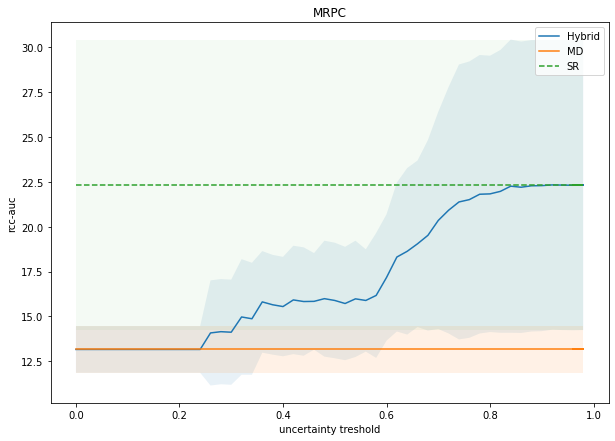

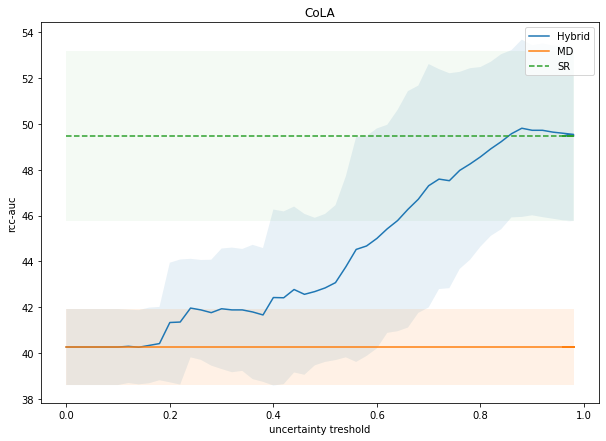

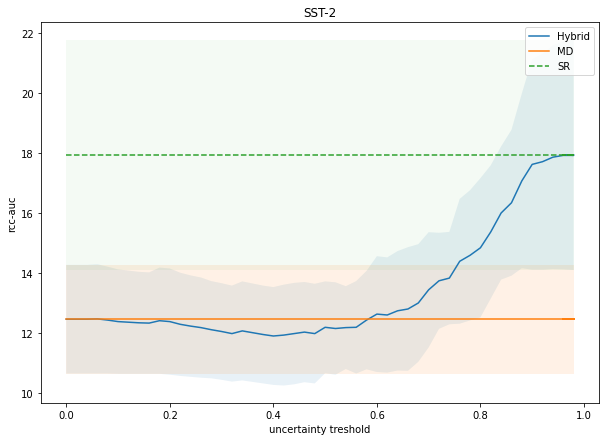

In [6]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x, y, label='Hybrid')
    plt.fill_between(x, y-y_std, y+y_std, alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

In [7]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0, :1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1, 0.02)

dataset_names = ['SST-5']
dataset_fnames = ['sst5']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../workdir/run_glue_for_model_series/electra_{reg}_no_sn/{name}/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_fo

In [8]:
table_res3 = pd.concat([pd.concat([t[:-1] for t in tables]), pd.concat(baselines[-1:])]).reset_index()

In [9]:
table_res3

,Method,UE Score,SST-5
,,,rcc-auc
0,mahalanobis|0.00,mahalanobis_distance,461.72±12.27
1,mahalanobis|0.02,mahalanobis_distance,461.35±11.70
2,mahalanobis|0.04,mahalanobis_distance,461.15±9.39
3,mahalanobis|0.06,mahalanobis_distance,459.92±7.89
4,mahalanobis|0.08,mahalanobis_distance,461.72±7.59
5,mahalanobis|0.10,mahalanobis_distance,460.71±7.54
6,mahalanobis|0.12,mahalanobis_distance,460.00±7.74
7,mahalanobis|0.14,mahalanobis_distance,459.38±8.62
8,mahalanobis|0.16,mahalanobis_distance,458.55±7.91


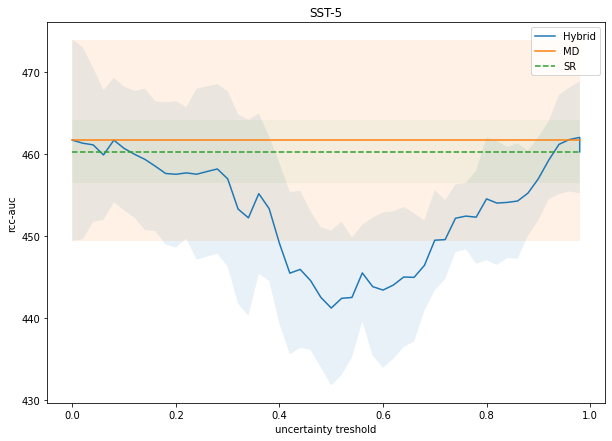

In [10]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x, y, label='Hybrid')
    plt.fill_between(x, y-y_std, y+y_std, alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

In [8]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0, :1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1, 0.02)

dataset_names = ['SST-5']
dataset_fnames = ['sst5']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/{name}/0.0/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/mahalanobis
../../../uncertainty-estimation_cp/workdir/run_tasks_for_model_series/electra_hs_rau_no_sn/sst5/0.0/maha

In [9]:
table_res3 = pd.concat([pd.concat([t[:-1] for t in tables]), pd.concat(baselines[-1:])]).reset_index()

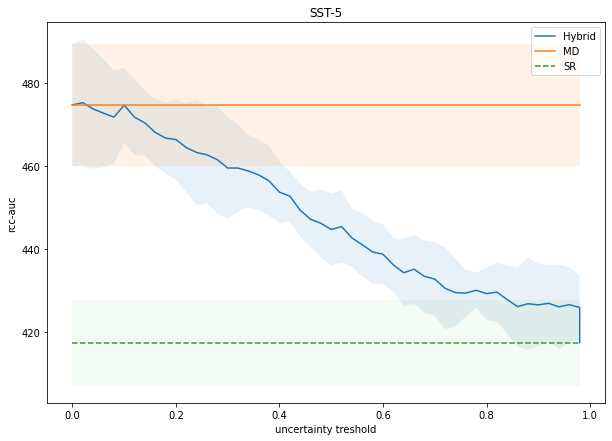

In [10]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x, y, label='Hybrid')
    plt.fill_between(x, y-y_std, y+y_std, alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

In [4]:
def aggregate_runs(data_path, methods, metric, task_type="classification", oos=False, avg_type='sum'):
    results = []
    model_results = []
    level = None
    for model_seed in os.listdir(data_path):
        try:
            model_seed_int = int(model_seed)
        except:
            if model_seed == "results":
                pass
            else:
                continue

        model_path = Path(data_path) / model_seed

        model_results = []

        for run_seed in os.listdir(model_path):
            run_dir = model_path / run_seed
            try:
                if task_type == "classification":
                    model_results.append(
                        extract_result(run_dir, methods=methods, metric=metric, oos=oos)
                    )
                    inf_time = extract_time(run_dir)
                    model_results[-1].update(inf_time)
                else:
                    level = task_type.split("-")[1]
                    model_results.append(
                        extract_result_ner(
                            run_dir, methods=methods, metric=metric, level=level, avg_type=avg_type
                        )
                    )
            except FileNotFoundError:
                pass
            except:
                continue

        model_avg_res = pd.DataFrame.from_dict(
            model_results, orient="columns"
        )  # .mean(axis=0)
        results.append(model_avg_res)

    results = pd.concat(results, axis=0)
    if level is not None:
        # ner case
        # TODO: changed df structure - now we calc mean by all exps, not by all models. Fix or add switch
        results = results.reset_index(drop=True)
    return results

In [5]:
def extract_result(time_dir, methods, metric="roc-auc", oos=False):
    seed = str(time_dir).split('/')[-1]
    maha_dir = f'../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst5/0.0/hybrid_adversarial/results/{seed}'
    
    try:
        with open(Path(time_dir) / "dev_inference.json", "r") as f:
            model_outputs = json.loads(f.read())
    except:
        with open(Path(time_dir) / "dev_inference.json", "r") as f:
            model_outputs = stable_json.loads(f.read())
            
    if "mahalanobis_distance" in model_outputs.keys():
        md = np.expand_dims(
            np.asarray(model_outputs["mahalanobis_distance"]), axis=(0, -1)
        )
    
    try:
        with open(Path(maha_dir) / "dev_inference.json", "r") as f:
            model_outputs1 = json.loads(f.read())
    except:
        with open(Path(maha_dir) / "dev_inference.json", "r") as f:
            model_outputs1 = stable_json.loads(f.read())
            
    if "mahalanobis_distance" in model_outputs.keys():
        adv = np.expand_dims(
            np.asarray(model_outputs1["mahalanobis_distance"]), axis=(0, -1)
        )
     
    sampled_probs = np.concatenate([md, adv], axis=0)    
    model_outputs["sampled_probabilities"] = sampled_probs

    if metric == "rejection-curve-auc":
        return calc_rejection_curve_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            np.asarray(model_outputs["answers"]),
            methods=methods,
        )
    elif metric == "roc-auc":
        return calc_roc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
            oos=oos,
        )

    elif callable(metric):
        try:
            return metric(model_outputs, methods=methods, oos=oos)
        except:
            return metric(model_outputs, methods=methods)
    else:
        raise ValueError(f"Error metric {metric}")


In [6]:
from scipy.stats import rankdata

def from_model_outputs_calc_rcc_auc(model_outputs, methods=None):
    used_methods = methods if methods is not None else default_methods
    if "sampled_probabilities" in model_outputs.keys():
        res = calc_rcc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
        )
    else:
        raise ValueError(f"Error keys {model_outputs.keys()}")
    return res

def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

def calc_rcc_aucs(probabilities, labels, sampled_probabilities, methods):
    predictions = np.argmax(probabilities, axis=-1)

    risk_binary = (predictions != labels).astype(int)

    conf = np.max(probabilities, axis=1)
    results = {}

    for name, method_function in methods.items():
        ue_scores = method_function(sampled_probabilities)
        unc_entropy = method_function(sampled_probabilities[:, 1:, :])
        n_preds = len(labels)
        n_lowest = int(n_preds*methods['theshold'])
        
        md_rank = rankdata(ue_scores)
        unc_entropy_rank = rankdata(-unc_entropy[md_rank < n_lowest])
        md_rank[md_rank < n_lowest] = unc_entropy_rank
        
        results[name] = rcc_auc(-md_rank, risk_binary)
        break

    results["max_prob"] = rcc_auc(conf, risk_binary)

    return results

In [25]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0, :1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1, 0.02)

dataset_names = ['SST-5']
dataset_fnames = ['sst5']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../workdir/run_glue_for_model_series/electra_raw_no_sn/{name}/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_fo

In [26]:
table_res3 = pd.concat([pd.concat([t for t in tables]), pd.concat(baselines[-1:])]).reset_index()

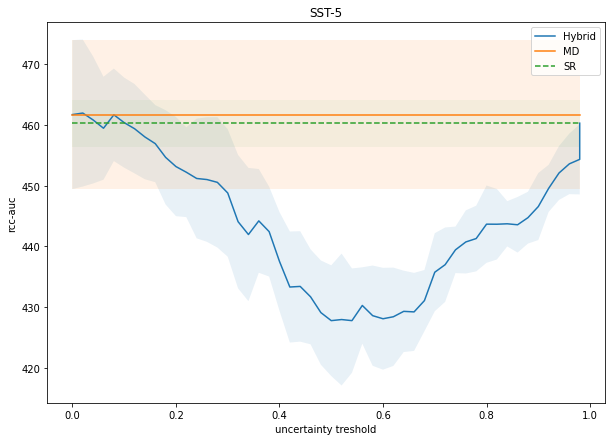

In [27]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x, y, label='Hybrid')
    plt.fill_between(x, y-y_std, y+y_std, alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

In [32]:
def extract_result(time_dir, methods, metric="roc-auc", oos=False):
    seed = str(time_dir).split('/')[-1]
    dataset = str(time_dir).split('/')[-5]
    maha_dir = f'../../workdir/run_tasks_for_model_series/electra_raw_no_sn/{dataset}/0.0/hybrid_adversarial/results/{seed}'
    
    try:
        with open(Path(time_dir) / "dev_inference.json", "r") as f:
            model_outputs = json.loads(f.read())
    except:
        with open(Path(time_dir) / "dev_inference.json", "r") as f:
            model_outputs = stable_json.loads(f.read())
            
    if "mahalanobis_distance" in model_outputs.keys():
        md = np.expand_dims(
            np.asarray(model_outputs["mahalanobis_distance"]), axis=(0, -1)
        )
    
    try:
        with open(Path(maha_dir) / "dev_inference.json", "r") as f:
            model_outputs1 = json.loads(f.read())
    except:
        with open(Path(maha_dir) / "dev_inference.json", "r") as f:
            model_outputs1 = stable_json.loads(f.read())
            
    if "mahalanobis_distance" in model_outputs.keys():
        adv = np.expand_dims(
            np.asarray(model_outputs1["mahalanobis_distance"]), axis=(0, -1)
        )
     
    sampled_probs = np.concatenate([md, adv], axis=0)    
    model_outputs["sampled_probabilities"] = sampled_probs

    if metric == "rejection-curve-auc":
        return calc_rejection_curve_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            np.asarray(model_outputs["answers"]),
            methods=methods,
        )
    elif metric == "roc-auc":
        return calc_roc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
            oos=oos,
        )

    elif callable(metric):
        try:
            return metric(model_outputs, methods=methods, oos=oos)
        except:
            return metric(model_outputs, methods=methods)
    else:
        raise ValueError(f"Error metric {metric}")


In [36]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0, :1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1, 0.02)

dataset_names = ['MRPC', 'CoLA', 'SST-2']
dataset_fnames = ['mrpc', 'cola', 'sst2']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_no_sn/{name}/noise_perc_0.0/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis

In [37]:
table_res3 = pd.concat([pd.concat([t for t in tables]), pd.concat(baselines[-1:])]).reset_index()

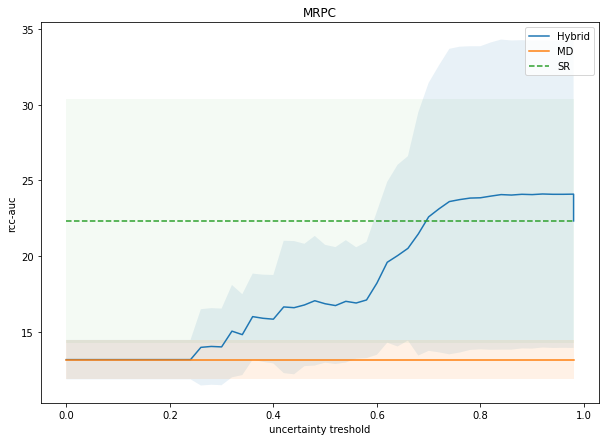

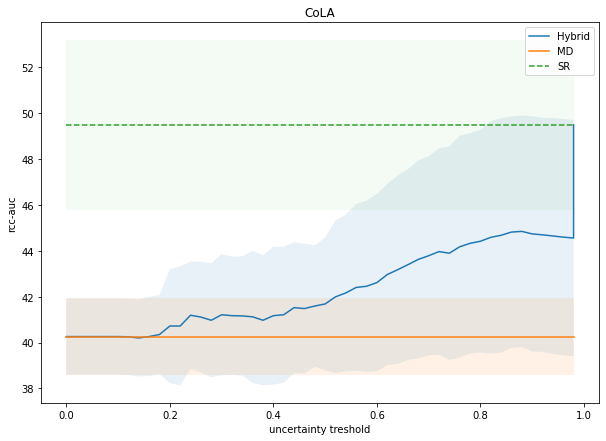

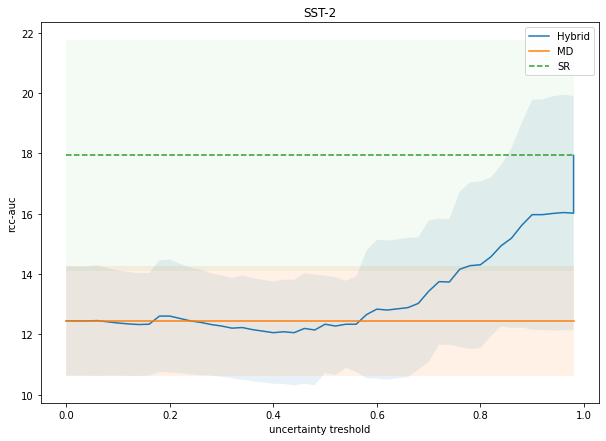

In [38]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x, y, label='Hybrid')
    plt.fill_between(x, y-y_std, y+y_std, alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

# MC dropout 

In [11]:
def aggregate_runs(data_path, methods, metric, task_type="classification", oos=False, avg_type='sum'):
    results = []
    model_results = []
    level = None
    for model_seed in os.listdir(data_path):
        try:
            model_seed_int = int(model_seed)
        except:
            if model_seed == "results":
                pass
            else:
                continue

        model_path = Path(data_path) / model_seed

        model_results = []

        for run_seed in os.listdir(model_path):
            run_dir = model_path / run_seed
            try:
                if task_type == "classification":
                    model_results.append(
                        extract_result(run_dir, methods=methods, metric=metric, oos=oos)
                    )
                    inf_time = extract_time(run_dir)
                    model_results[-1].update(inf_time)
                else:
                    level = task_type.split("-")[1]
                    model_results.append(
                        extract_result_ner(
                            run_dir, methods=methods, metric=metric, level=level, avg_type=avg_type
                        )
                    )
            except FileNotFoundError:
                pass
            except:
                continue

        model_avg_res = pd.DataFrame.from_dict(
            model_results, orient="columns"
        )  # .mean(axis=0)
        results.append(model_avg_res)

    results = pd.concat(results, axis=0)
    if level is not None:
        # ner case
        # TODO: changed df structure - now we calc mean by all exps, not by all models. Fix or add switch
        results = results.reset_index(drop=True)
    return results

In [12]:
def extract_result(time_dir, methods, metric="roc-auc", oos=False):
    mc_dir = str(time_dir).replace('mahalanobis', 'mc')
    
    try:
        with open(Path(time_dir) / "dev_inference.json", "r") as f:
            model_outputs = json.loads(f.read())
    except:
        with open(Path(time_dir) / "dev_inference.json", "r") as f:
            model_outputs = stable_json.loads(f.read())
    if "mahalanobis_distance" in model_outputs.keys():
        sampled_probs = np.expand_dims(
            np.asarray(model_outputs["mahalanobis_distance"]), axis=(0, -1)
        )
        model_outputs["sampled_probabilities"] = sampled_probs.tolist()
        
    mc_dir = str(time_dir).replace('mahalanobis', 'mc')
    try:
        with open(Path(mc_dir) / "dev_inference.json", "r") as f:
            model_outputs1 = json.loads(f.read())
    except:
        with open(Path(mc_dir) / "dev_inference.json", "r") as f:
            model_outputs1 = stable_json.loads(f.read())
            
    sampled_mc = np.asarray(model_outputs1["sampled_probabilities"])
    sampled_probs = np.concatenate([np.repeat(sampled_probs, sampled_mc.shape[-1], axis=2), sampled_mc], axis=0)
    
    model_outputs["sampled_probabilities"] = sampled_probs.tolist()

    if metric == "rejection-curve-auc":
        return calc_rejection_curve_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            np.asarray(model_outputs["answers"]),
            methods=methods,
        )
    elif metric == "roc-auc":
        return calc_roc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
            oos=oos,
        )

    elif callable(metric):
        try:
            return metric(model_outputs, methods=methods, oos=oos)
        except:
            return metric(model_outputs, methods=methods)
    else:
        raise ValueError(f"Error metric {metric}")


In [91]:
from scipy.stats import rankdata


def from_model_outputs_calc_rcc_auc(model_outputs, methods=None):
    used_methods = methods if methods is not None else default_methods
    if "sampled_probabilities" in model_outputs.keys():
        res = calc_rcc_aucs(
            np.asarray(model_outputs["probabilities"]),
            np.asarray(model_outputs["true_labels"]),
            np.asarray(model_outputs["sampled_probabilities"]).transpose(1, 0, 2),
            methods=methods,
        )
    else:
        raise ValueError(f"Error keys {model_outputs.keys()}")
    return res

def rcc_auc(conf, risk, return_points=False):
    # risk-coverage curve's area under curve
    n = len(conf)
    cr_pair = list(zip(conf, risk))
    cr_pair.sort(key=lambda x: x[0], reverse=True)

    cumulative_risk = [cr_pair[0][1]]
    for i in range(1, n):
        cumulative_risk.append(cr_pair[i][1] + cumulative_risk[-1])

    points_x = []
    points_y = []

    auc = 0
    for k in range(n):
        auc += cumulative_risk[k] / (1 + k)
        points_x.append((1 + k) / n)  # coverage
        points_y.append(cumulative_risk[k] / (1 + k))  # current avg. risk

    if return_points:
        return auc, points_x, points_y
    else:
        return auc

def calc_rcc_aucs(probabilities, labels, sampled_probabilities, methods):
    predictions = np.argmax(probabilities, axis=-1)

    risk_binary = (predictions != labels).astype(int)

    conf = np.max(probabilities, axis=1)
    results = {}

    for name, method_function in methods.items():
        ue_scores = method_function(sampled_probabilities)
        unc_entropy = mean_entropy(sampled_probabilities[:, 1:, :])
        n_preds = len(labels)
        n_lowest = int(n_preds*methods['theshold'])
        
        md_rank = rankdata(ue_scores)
        unc_entropy_rank = rankdata(unc_entropy[md_rank < n_lowest])
        md_rank[md_rank < n_lowest] = unc_entropy_rank
        
        results[name] = rcc_auc(-md_rank, risk_binary)
        break

    results["max_prob"] = rcc_auc(conf, risk_binary)

    return results

In [14]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0, :1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1, 0.02)

dataset_names = ['MRPC', 'CoLA', 'SST-2']
dataset_fnames = ['mrpc', 'cola', 'sst2']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../workdir/run_tasks_for_model_series/electra_{reg}_no_sn/{name}/noise_perc_0.0/{method}'
                run_dirs.append([model_series_dir])
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis
../../workdir/run_tasks_for_model_series/electra_raw_no_sn/sst2/noise_perc_0.0/mahalanobis

In [15]:
table_res3 = pd.concat([pd.concat([t for t in tables]), pd.concat(baselines[-1:])]).reset_index()

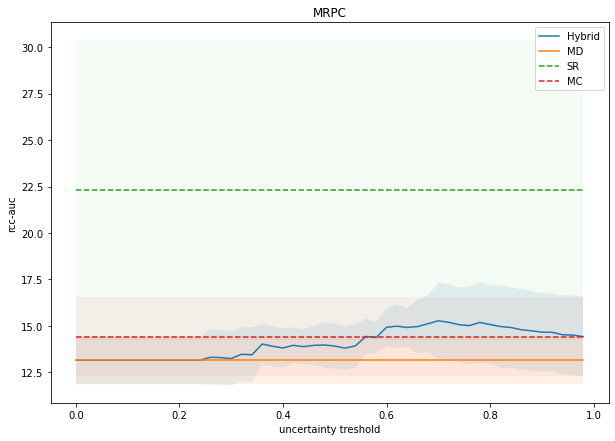

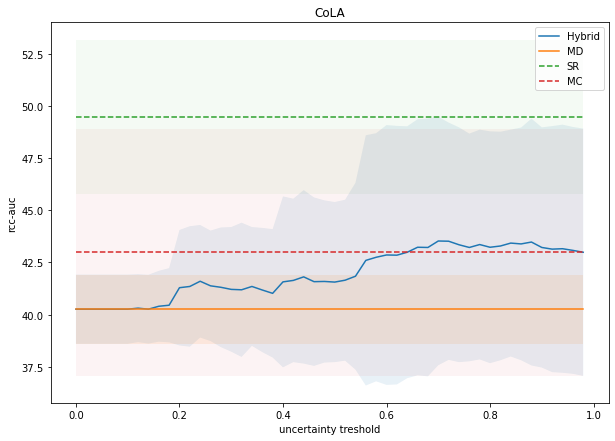

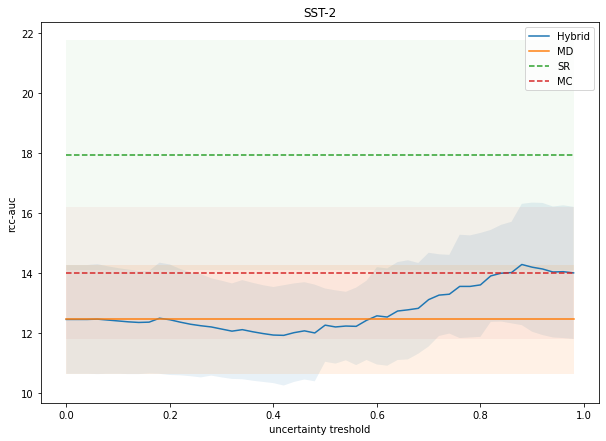

In [16]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x[:-1], y[:-1], label='Hybrid')
    plt.fill_between(x[:-1], y[:-1]-y_std[:-1], y[:-1]+y_std[:-1], alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    y_mc = np.array([y[-2]]*len(x))
    plt.plot(x, y_mc, '--', label='MC')
    plt.fill_between(x, y_mc-y_std[-2], y_mc+y_std[-2], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

In [17]:
import os 

def choose_agg_func(method, theshold=0.0):
    agg_methods = {
        "bald": bald,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
        "sampled_entropy": mean_entropy,
    }
    if method=='mahalanobis':
        maha_dist = lambda x: np.squeeze(x[:, 0, :1], axis=-1)
        agg_methods = {"mahalanobis_distance": maha_dist,
                       "theshold": theshold}
    return agg_methods

metric_types=["rcc-auc"]
methods = ['mahalanobis']
regs = ['raw']
thesholds = np.arange(0, 1.02, 0.02)

dataset_names = ['SST-5']
dataset_fnames = ['sst5']
names = []
tables = []
baselines = []
for method in methods:
    for reg in regs:
        for theshold in thesholds:
            run_dirs = []
            names = [f'{method}|{theshold:.2f}']
            agg_func = choose_agg_func(method, theshold)
            for name in dataset_fnames:
                model_series_dir = f'../../workdir/run_glue_for_model_series/electra_{reg}_no_sn/{name}/{method}'
                run_dirs.append([model_series_dir])
            res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
            try:
                res_df = collect_datasets(run_dirs, names, dataset_names, metric_types=metric_types, methods=agg_func)
                baselines.append(res_df.iloc[-1:])
                tables.append(res_df.iloc[:-1])
                print(model_series_dir)
            except:
                print(f'Not exists one of this dirs: {run_dirs}')

../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_for_model_series/electra_raw_no_sn/sst5/mahalanobis
../../workdir/run_glue_fo

In [18]:
table_res3 = pd.concat([pd.concat([t for t in tables]), pd.concat(baselines[-1:])]).reset_index()

In [19]:
table_res3

,Method,UE Score,SST-5
,,,rcc-auc
0,mahalanobis|0.00,mahalanobis_distance,461.72±12.27
1,mahalanobis|0.02,mahalanobis_distance,461.48±11.51
2,mahalanobis|0.04,mahalanobis_distance,461.03±9.40
3,mahalanobis|0.06,mahalanobis_distance,460.11±7.31
4,mahalanobis|0.08,mahalanobis_distance,461.63±7.18
5,mahalanobis|0.10,mahalanobis_distance,460.32±7.69
6,mahalanobis|0.12,mahalanobis_distance,459.64±7.76
7,mahalanobis|0.14,mahalanobis_distance,458.92±8.28
8,mahalanobis|0.16,mahalanobis_distance,458.38±7.68


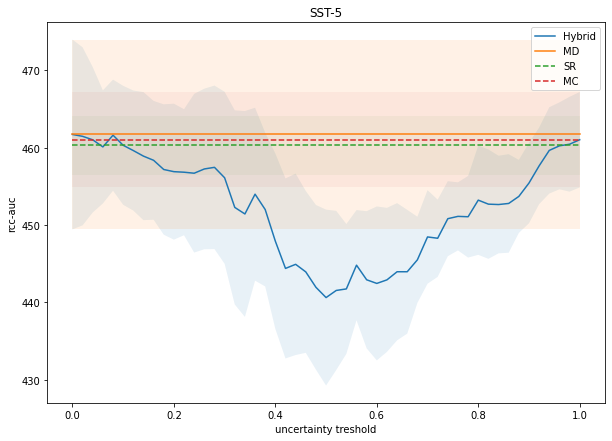

In [20]:
import matplotlib.pyplot as plt

for dataset in dataset_names:
    plt.figure(figsize=(10, 7))
    
    y = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[0])).values
    y_std = table_res3[(dataset, 'rcc-auc')].apply(lambda x: float(x.split('±')[1])).values
    x = table_res3['Method'].apply(lambda x: float(x.split('|')[1])).values
    plt.title(dataset)
    plt.plot(x[:-1], y[:-1], label='Hybrid')
    plt.fill_between(x[:-1], y[:-1]-y_std[:-1], y[:-1]+y_std[:-1], alpha=.1)
    
    y_md = np.array([y[0]]*len(x))
    plt.plot(x, y_md, label='MD')
    plt.fill_between(x, y_md-y_std[0], y_md+y_std[0], alpha=.1)
    
    y_ent = np.array([y[-1]]*len(x))
    plt.plot(x, y_ent, '--', label='SR')
    plt.fill_between(x, y_ent-y_std[-1], y_ent+y_std[-1], alpha=.05)
    
    y_mc = np.array([y[-2]]*len(x))
    plt.plot(x, y_mc, '--', label='MC')
    plt.fill_between(x, y_mc-y_std[-2], y_mc+y_std[-2], alpha=.05)
    
    plt.xlabel('uncertainty treshold')
    plt.ylabel('rcc-auc')
    
    plt.legend()
    plt.show()

In [98]:
import json
from pathlib import Path

time_dir = '/home/jovyan/uncertainty-estimation/workdir/run_tasks_for_model_series/electra_raw_no_sn/sst5/0.0/hybrid_adversarial/results/705525'
with open(Path(time_dir) / "dev_inference.json", "r") as f:
    model_outputs = json.loads(f.read())

In [99]:
model_outputs.keys()

dict_keys(['true_labels', 'eval_score', 'probabilities', 'answers', 'mahalanobis_distance', 'ue_time', 'eval_time'])

In [100]:
labels = np.array(model_outputs['true_labels'])
predictions = np.argmax(np.array(model_outputs['probabilities']), axis=-1)
risk_binary = (predictions != labels).astype(int)
rcc_auc(np.array(model_outputs['mahalanobis_distance']), risk_binary)

451.56269695756475